In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from neuron import h
from neuron.units import ms, mV
from sbi import utils as utils
from sbi.inference.base import infer
import torch
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

In [2]:
print(os.system('nrnivmodl')) # compile modfiles. Return 0 for success, 1 for failure.
h.load_file('stdrun.hoc')

512


1.0

In [3]:
def model(params):
    h.dt = 0.025 # time step (resolution) of the simulation in ms
    h.v_init= -60 # initial membrane potential in mV

# Cell geometry and biophysics
    soma = h.Section(name='soma')
    soma.diam = 18.8 #um
    soma.L = 18.8 #um
    soma.Ra = 123 # ohm-cm
    soma.cm = 1 #uF/cm2

    soma.insert('leak') # Leak channel
    soma.glbar_leak = params[0]#0.0003 # S/cm2
    soma.el_leak = -60 # mV
    soma.insert('na') # Sodium channel
    gnabar = params[2]#0.12 # S/cm2
    soma.nao = 79.8 # extracellular Na concentration
    soma.insert('k') # Potassium channel
    gkbar = params[1]#0.036 # S/cm2
    soma.ki = 69.35 # intracellular K concentration

#creating current clamp in the middle of the soma
    iclamp = h.IClamp(soma(0.5))
    iclamp.delay = 100 # ms
    iclamp.dur = 100 # ms
    iclamp.amp = 0.2 #nA


#recording variables
    v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
    t = h.Vector().record(h._ref_t) 

    h.load_file('stdrun.hoc')
    h.finitialize(-65 * mV)## vrest
    h.continuerun(300 * ms)## simulation time
    return np.array(v)

In [4]:
from scipy import stats as spstats
from scipy.signal import find_peaks
def Stats(trace):
    """
    Calculates summary statistics
    results = model(params)
    """
    trace = np.asarray(trace)
    
    avg = np.mean(trace) # average voltage
    stdDev = np.std(trace) # stDev of the voltage
    Max  = np.argmax(trace)
    Min = np.argmin(trace)
    peak_times = np.asarray(find_peaks(trace)[0])
    firstPeak = peak_times[0]
    allStats = np.concatenate((avg,stdDev,Max,Min,firstPeak),axis=None)
   
    return np.array(allStats)

In [5]:
true_params = np.array([0.00001,0.036,0.12])

torch.from_numpy(Stats(model(true_params)))

tensor([ -62.0543,   22.8723, 4053.0000, 8042.0000, 4053.0000],
       dtype=torch.float64)

In [6]:
def simulation_wrapper(params):
    obs = model(params)#get only the voltage trace
    summstats = torch.from_numpy(Stats(obs))
    return summstats

In [7]:
Lows = torch.tensor([0.0001,0.001,0.09], dtype=float)
Highs = torch.tensor([0.001,0.025,0.4], dtype=float)
prior = utils.BoxUniform(low=Lows,high=Highs)

In [8]:
simulator, prior = prepare_for_sbi(simulation_wrapper, prior)

In [9]:
density_estimator = posterior_nn(model='maf',hidden_features=12)
inference = SNPE(prior=prior,density_estimator=density_estimator,show_progress_bars=True)

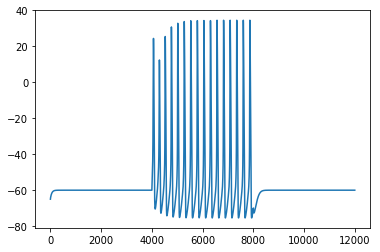

In [10]:
plt.plot(model(prior.sample()))

In [11]:
Stats(model(true_params))

array([ -62.05433027,   22.87230515, 4053.        , 8042.        ,
       4053.        ])

In [12]:
posteriors = []
proposal = prior
num_rounds=2
x_o = torch.from_numpy(Stats(model(true_params)))
torch.manual_seed(0)

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal,num_simulations=1000)
    
     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(show_train_summary=True,use_combined_loss=True)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/mizzou/tools/utils/conda/envs/py36/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Neural network successfully converged after 207 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 207
        Best validation performance: 15.3482
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the remaining
                        995 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
Neural network successfully converged after 86 epochs.

        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 86
        Best validation performance: 6.5257
        -------------------------
        


In [13]:
observation_trace = x_o
observation_summary_statistics = observation_trace
samples = posterior.sample((10000,), x=x_o)#,sample_with_mcmc=True)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
log_probability = posterior.log_prob(samples, x = x_o)#,norm_posterior=False)
predicted_post_index = np.argmin(log_probability)
predicted_post = samples[predicted_post_index]

print("predicted post is: ",predicted_post)

predicted post is:  tensor([0.0005, 0.0104, 0.2837])


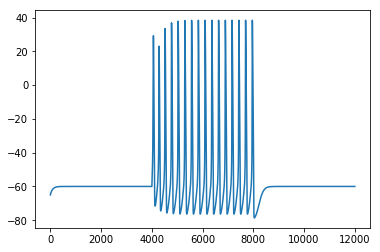

In [15]:
plt.plot(model(predicted_post))



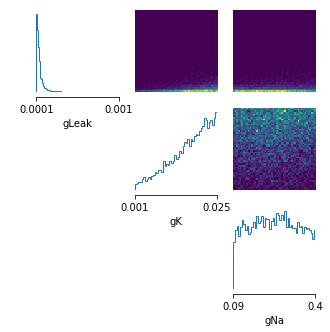

In [16]:
labels_params = ['gLeak', 'gK','gNa']
fig, axes = utils.pairplot(samples,
                           limits=[[Lows[0],Highs[0]],[Lows[1],Highs[1]],[Lows[2],Highs[2]]],
                           ticks=[[Lows[0],Highs[0]],[Lows[1],Highs[1]],[Lows[2],Highs[2]]],
                           fig_size=(5,5),
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r');

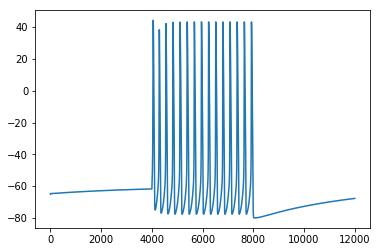

In [17]:
plt.plot(model(true_params))


In [18]:
print("correlation coefficient between true and predicted = %f" %np.corrcoef(model(true_params),model(predicted_post))[0][1])

correlation coefficient between true and predicted = 0.009990


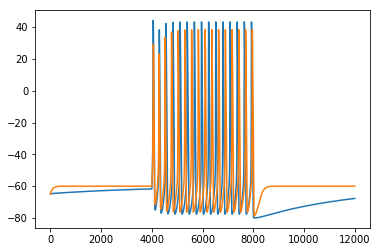

In [19]:
plt.plot(model(true_params))
plt.plot(model(predicted_post))